# NGDS Assignment 1 — Machine Learning Modelling on a Real-World Dataset

**Module:** Next Generation Data Science (NGDS)  
**Theme:** Finance — Credit Card Fraud Detection  
**Institution:** University of Hertfordshire  
**Student:** Yogaraj Kumaresan  





---
## 1. Installation & required library

In [56]:
!pip install -q imbalanced-learn shap
print('Done.')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, GridSearchCV,
    StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    f1_score, matthews_corrcoef,
    ConfusionMatrixDisplay, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
import shap

SEED = 42
np.random.seed(SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False
})

import sklearn
print(f'numpy   {np.__version__}')
print(f'pandas  {pd.__version__}')
print(f'sklearn {sklearn.__version__}')
print('All libraries loaded.')

Done.
numpy   2.0.2
pandas  2.2.2
sklearn 1.6.1
All libraries loaded.


---
## 2. Dataset Loading & Inspection

In [57]:
# Load dataset — upload creditcard.csv to Colab first
df = pd.read_csv('creditcard.csv')

# Basic info
n_fraud  = int(df['Class'].sum())
n_legit  = len(df) - n_fraud
fraud_pc = n_fraud / len(df) * 100

print('=' * 50)
print('DATASET OVERVIEW')
print('=' * 50)
print(f'Rows            : {len(df):,}')
print(f'Columns         : {df.shape[1]}')
print(f'Missing values  : {df.isnull().sum().sum()}')
print(f'Duplicate rows  : {df.duplicated().sum()}')
print(f'Legitimate (0)  : {n_legit:,}  ({100-fraud_pc:.3f}%)')
print(f'Fraudulent (1)  : {n_fraud:,}  ({fraud_pc:.3f}%)')
print(f'Imbalance ratio : {n_legit/n_fraud:.1f}:1')
df.head()

DATASET OVERVIEW
Rows            : 21,878
Columns         : 31
Missing values  : 2
Duplicate rows  : 81
Legitimate (0)  : 21,792  (99.607%)
Fraudulent (1)  : 86  (0.393%)
Imbalance ratio : 253.4:1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [58]:
print('Descriptive Statistics — Time & Amount')
print(df[['Time','Amount']].describe().round(3).to_string())

Descriptive Statistics — Time & Amount
            Time     Amount
count  21878.000  21877.000
mean   16924.272     71.725
std    11005.410    205.035
min        0.000      0.000
25%     5496.250      5.990
50%    18770.500     17.430
75%    27778.750     62.390
max    31907.000   7879.420


---
## 3. Exploratory Data Analysis

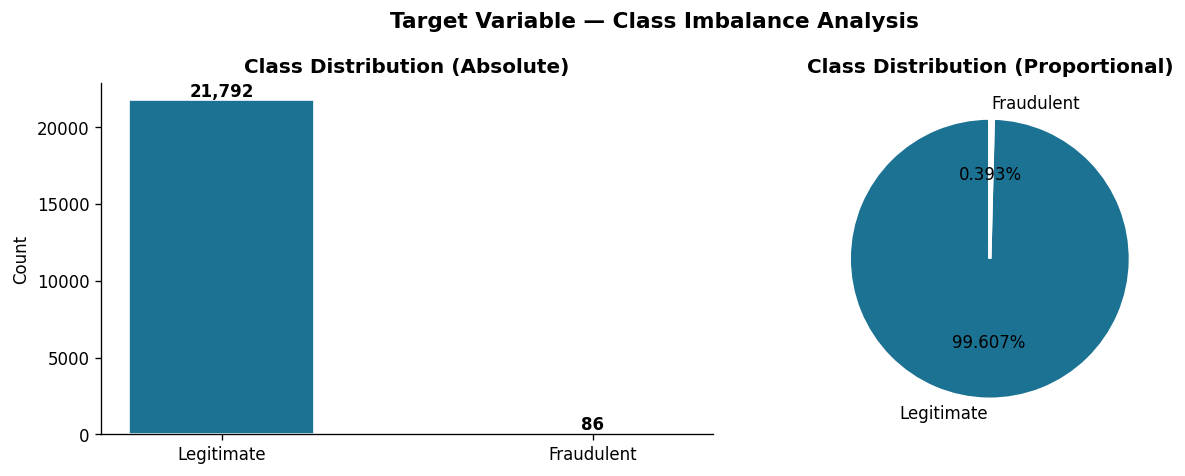

Severe imbalance confirmed. AUPRC and F1 used as primary metrics.


In [59]:
# 3.1 Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].bar(['Legitimate','Fraudulent'],
            [n_legit, n_fraud],
            color=['#1C7293','#E05C5C'],
            width=0.5, edgecolor='white')
for i, (label, count) in enumerate([('Legitimate', n_legit),
                                      ('Fraudulent', n_fraud)]):
    axes[0].text(i, count + 200, f'{count:,}',
                 ha='center', fontweight='bold')
axes[0].set_title('Class Distribution (Absolute)', fontweight='bold')
axes[0].set_ylabel('Count')

axes[1].pie([n_legit, n_fraud],
            labels=['Legitimate','Fraudulent'],
            colors=['#1C7293','#E05C5C'],
            autopct='%1.3f%%', startangle=90,
            wedgeprops={'edgecolor':'white','linewidth':2})
axes[1].set_title('Class Distribution (Proportional)', fontweight='bold')

plt.suptitle('Target Variable — Class Imbalance Analysis',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', bbox_inches='tight', dpi=150)
plt.show()
print('Severe imbalance confirmed. AUPRC and F1 used as primary metrics.')

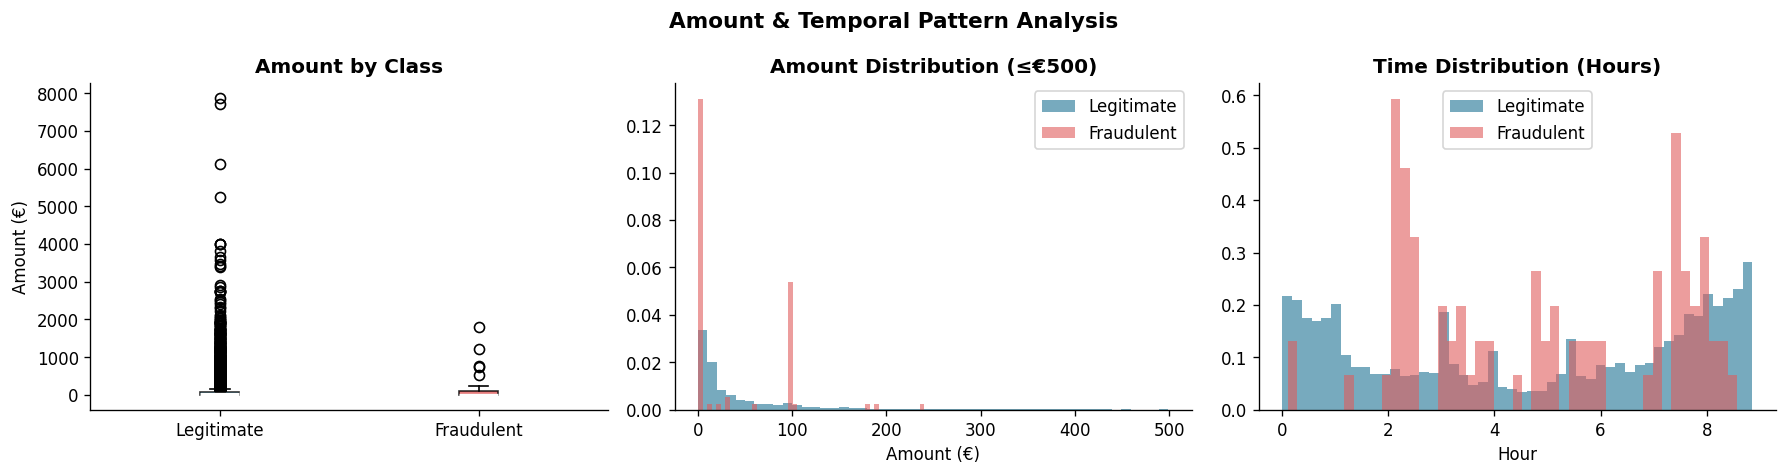

Fraudulent median: €1.00
Legitimate median: €17.50


In [60]:
# 3.2 Amount & Time Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Boxplot
bp = axes[0].boxplot(
    [df[df['Class']==0]['Amount'].values,
     df[df['Class']==1]['Amount'].values],
    labels=['Legitimate','Fraudulent'],
    patch_artist=True,
    medianprops={'color':'white','linewidth':2}
)
for patch, color in zip(bp['boxes'], ['#1C7293','#E05C5C']):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
axes[0].set_title('Amount by Class', fontweight='bold')
axes[0].set_ylabel('Amount (€)')

# Amount histogram
for cls, color, lbl in [(0,'#1C7293','Legitimate'),
                         (1,'#E05C5C','Fraudulent')]:
    vals = df.loc[df['Class']==cls,'Amount'].values
    axes[1].hist(vals[vals<500], bins=50, alpha=0.6,
                 color=color, label=lbl, density=True)
axes[1].set_title('Amount Distribution (≤€500)', fontweight='bold')
axes[1].set_xlabel('Amount (€)')
axes[1].legend()

# Time
for cls, color, lbl in [(0,'#1C7293','Legitimate'),
                         (1,'#E05C5C','Fraudulent')]:
    times = df.loc[df['Class']==cls,'Time'].values / 3600
    axes[2].hist(times, bins=48, alpha=0.6,
                 color=color, label=lbl, density=True)
axes[2].set_title('Time Distribution (Hours)', fontweight='bold')
axes[2].set_xlabel('Hour')
axes[2].legend()

plt.suptitle('Amount & Temporal Pattern Analysis',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('amount_time.png', bbox_inches='tight', dpi=150)
plt.show()

print(f'Fraudulent median: €{df.loc[df["Class"]==1,"Amount"].median():.2f}')
print(f'Legitimate median: €{df.loc[df["Class"]==0,"Amount"].median():.2f}')

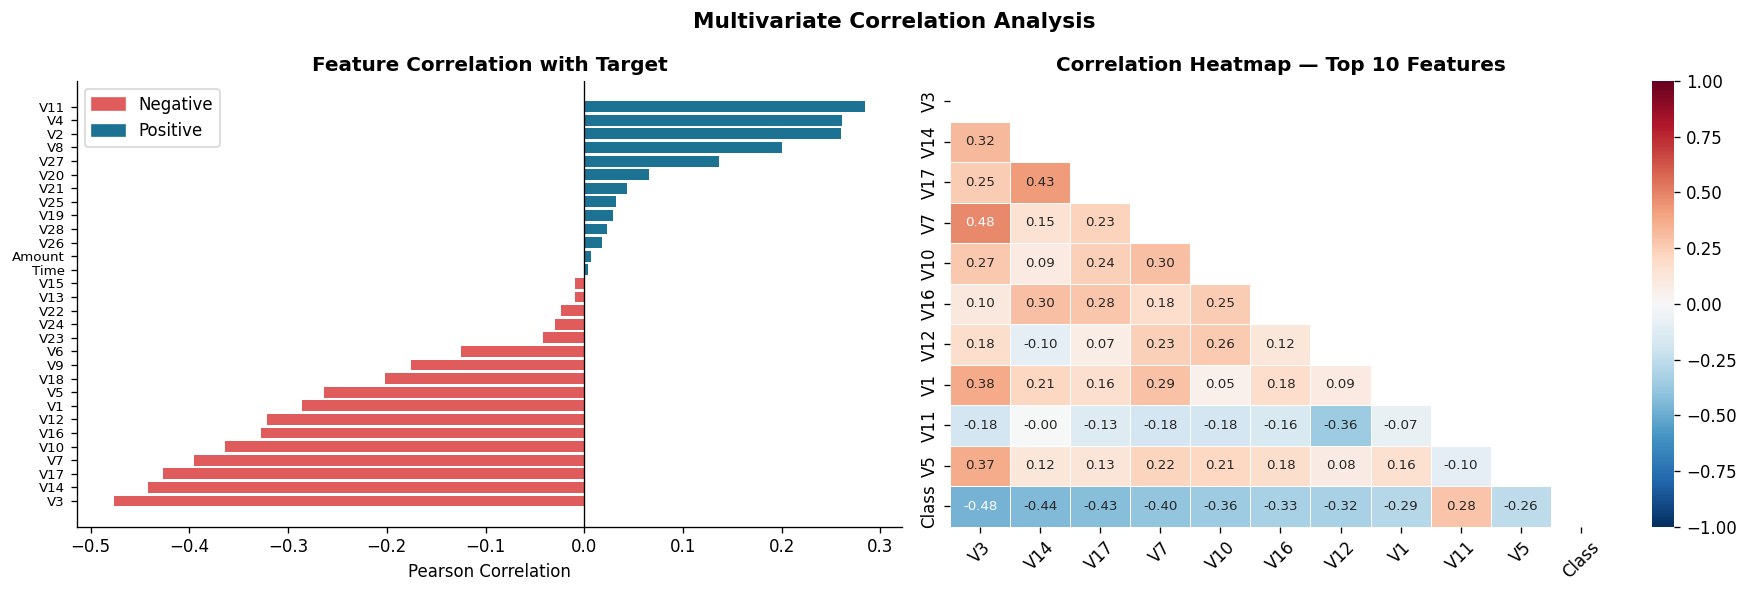

Top 5 positive correlations with fraud:
V11    0.2842
V4     0.2615
V2     0.2600
V8     0.2006
V27    0.1360

Top 5 negative correlations with fraud:
V3    -0.4763
V14   -0.4418
V17   -0.4263
V7    -0.3957
V10   -0.3636


In [61]:
# 3.3 Correlation Analysis
correlations = df.corr(numeric_only=True)['Class'].drop('Class').sort_values()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

colors_bar = ['#E05C5C' if c < 0 else '#1C7293'
              for c in correlations]
axes[0].barh(range(len(correlations)),
             correlations.values, color=colors_bar)
axes[0].set_yticks(range(len(correlations)))
axes[0].set_yticklabels(correlations.index, fontsize=8)
axes[0].axvline(x=0, color='black', linewidth=0.8)
axes[0].set_title('Feature Correlation with Target',
                  fontweight='bold')
axes[0].set_xlabel('Pearson Correlation')
axes[0].legend(handles=[
    mpatches.Patch(color='#E05C5C', label='Negative'),
    mpatches.Patch(color='#1C7293', label='Positive')
])

top_feats = list(correlations.abs().nlargest(10).index) + ['Class']
corr_m = df[top_feats].corr(numeric_only=True)
mask   = np.triu(np.ones_like(corr_m, dtype=bool))
sns.heatmap(corr_m, mask=mask, ax=axes[1],
            cmap='RdBu_r', vmin=-1, vmax=1,
            center=0, annot=True, fmt='.2f',
            annot_kws={'size':8},
            linewidths=0.5, linecolor='white')
axes[1].set_title('Correlation Heatmap — Top 10 Features',
                  fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Multivariate Correlation Analysis',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation.png', bbox_inches='tight', dpi=150)
plt.show()

print('Top 5 positive correlations with fraud:')
print(correlations[correlations>0].nlargest(5).round(4).to_string())
print('\nTop 5 negative correlations with fraud:')
print(correlations[correlations<0].nsmallest(5).round(4).to_string())

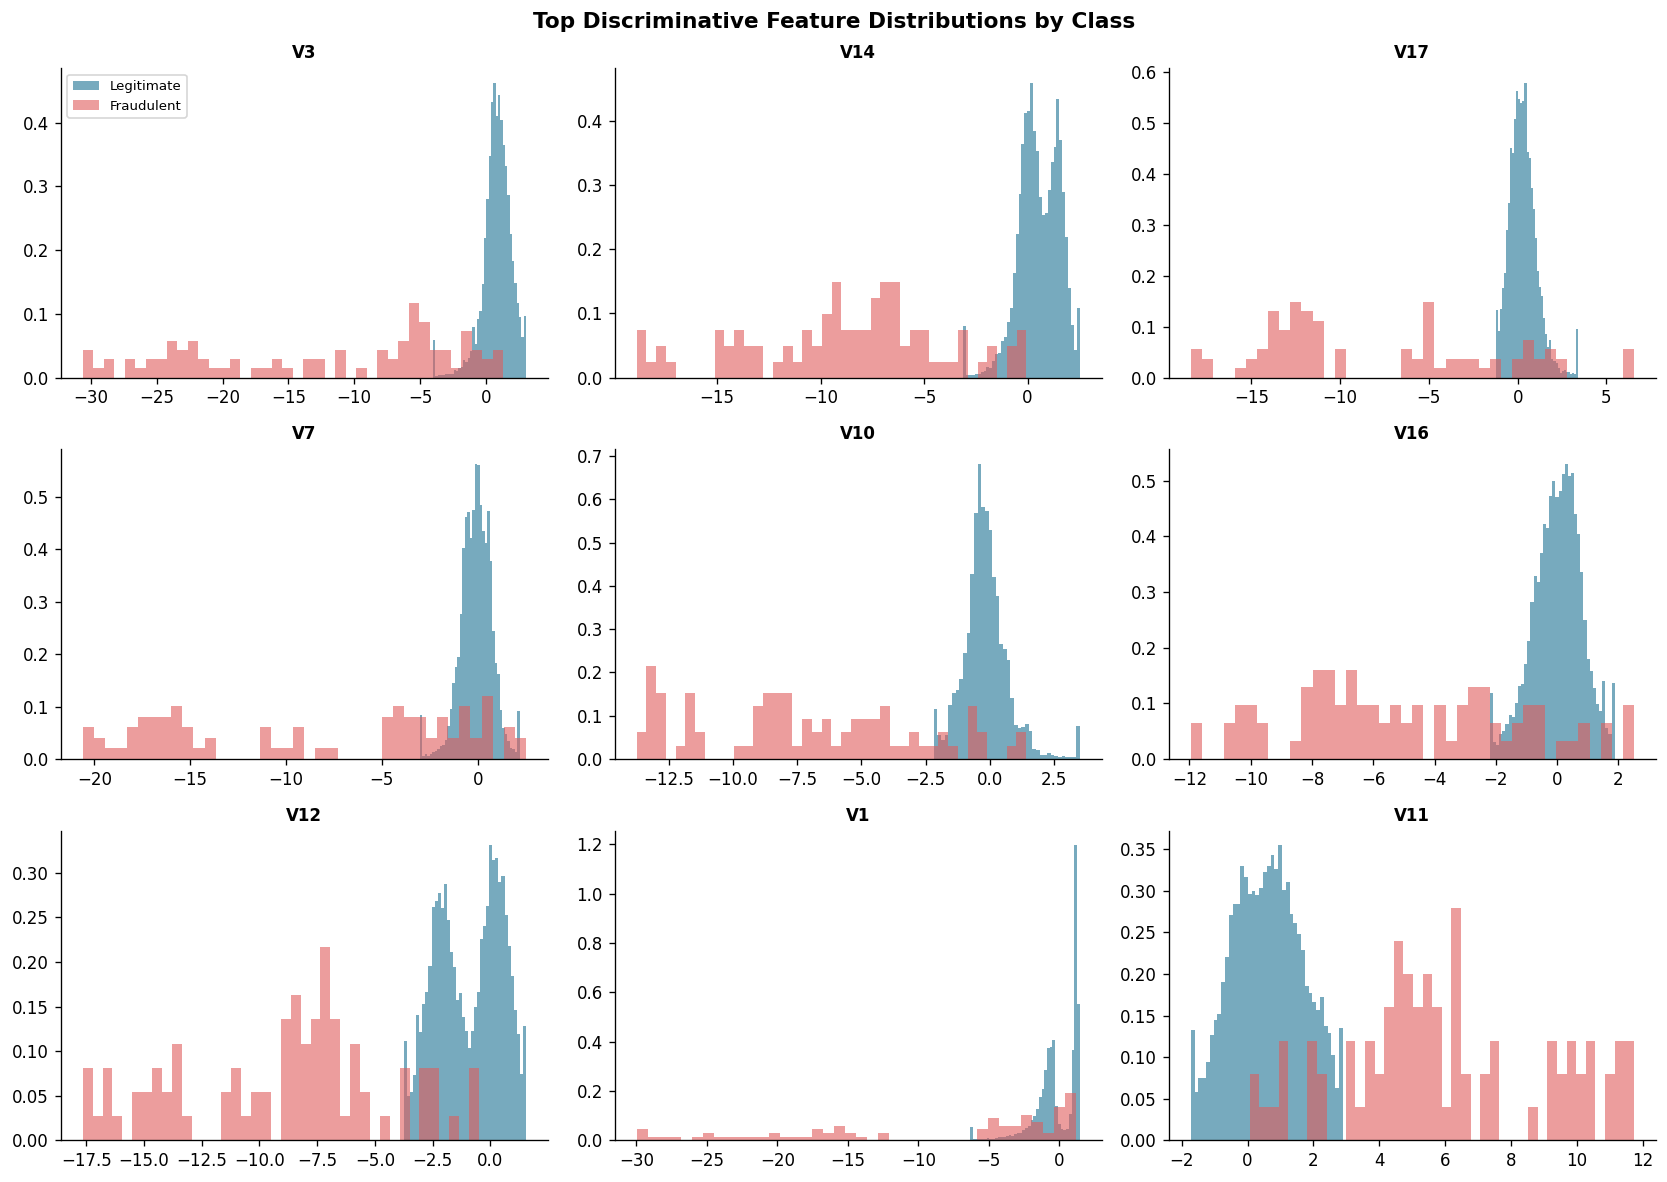

In [62]:
# 3.4 Feature Distributions by Class — Top 9
top9 = correlations.abs().nlargest(9).index.tolist()

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(top9):
    ax = axes[i]
    for cls, color, lbl in [(0,'#1C7293','Legitimate'),
                             (1,'#E05C5C','Fraudulent')]:
        data = df.loc[df['Class']==cls, feat].values
        low, high = np.percentile(data, [1, 99])
        ax.hist(np.clip(data, low, high),
                bins=40, alpha=0.6, color=color,
                label=lbl, density=True)
    ax.set_title(feat, fontweight='bold', fontsize=10)
    if i == 0:
        ax.legend(fontsize=8)

plt.suptitle('Top Discriminative Feature Distributions by Class',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_distributions.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 4. Preprocessing Pipeline

In [63]:
# ── Step 1: Remove duplicates
df_clean = df.drop_duplicates().reset_index(drop=True)
print(f'Rows after dedup: {len(df_clean):,} '
      f'(removed {len(df)-len(df_clean):,})')

# ── Handle missing values before feature engineering
df_clean.dropna(inplace=True)
print(f'Rows after dropping NaNs: {len(df_clean):,}')

# ── Step 2: Feature engineering
df_clean['log_Amount'] = np.log1p(df_clean['Amount'])
df_clean['hour_of_day'] = (df_clean['Time'] / 3600) % 24

# ── Step 3: Separate features & target — convert to numpy immediately
# This avoids all pandas KeyError / alignment issues
drop_cols = ['Time', 'Amount', 'Class']
feature_names = [c for c in df_clean.columns if c not in drop_cols]

X_all = df_clean[feature_names].values   # numpy array
y_all = df_clean['Class'].values          # numpy array

print(f'X shape        : {X_all.shape}')
print(f'y shape        : {y_all.shape}')
print(f'Fraud in y     : {y_all.sum():,} ({y_all.mean()*100:.3f}%)')
print(f'Features       : {len(feature_names)}')
print(f'Feature list   : {feature_names[:5]} ... {feature_names[-2:]}')

# ── Step 4: Stratified 70 / 15 / 15 split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all,
    test_size=0.15,
    stratify=y_all,
    random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,   # 0.1765 x 0.85 ≈ 0.15
    stratify=y_temp,
    random_state=SEED
)

print(f'\nSplit summary:')
print(f'  Train : {X_train.shape[0]:,} rows | '
      f'Fraud: {y_train.sum():,} ({y_train.mean()*100:.3f}%)')
print(f'  Val   : {X_val.shape[0]:,}  rows | '
      f'Fraud: {y_val.sum():,}  ({y_val.mean()*100:.3f}%)')
print(f'  Test  : {X_test.shape[0]:,}  rows | '
      f'Fraud: {y_test.sum():,}  ({y_test.mean()*100:.3f}%)')

# ── Step 5: RobustScaler — fit on TRAIN only
scaler       = RobustScaler()
X_train_sc   = scaler.fit_transform(X_train)
X_val_sc     = scaler.transform(X_val)
X_test_sc    = scaler.transform(X_test)

# ── Step 6: SMOTE — on TRAIN only
smote = SMOTE(random_state=SEED, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_sc, y_train)

print(f'\nAfter SMOTE (train only):')
print(f'  Total   : {len(X_train_res):,}')
print(f'  Legit   : {(y_train_res==0).sum():,}')
print(f'  Fraud   : {(y_train_res==1).sum():,}')
print('\n✅ Preprocessing complete — no data leakage.')

Rows after dedup: 21,797 (removed 81)
Rows after dropping NaNs: 21,796
X shape        : (21796, 30)
y shape        : (21796,)
Fraud in y     : 86.0 (0.395%)
Features       : 30
Feature list   : ['V1', 'V2', 'V3', 'V4', 'V5'] ... ['log_Amount', 'hour_of_day']

Split summary:
  Train : 15,256 rows | Fraud: 60.0 (0.393%)
  Val   : 3,270  rows | Fraud: 13.0  (0.398%)
  Test  : 3,270  rows | Fraud: 13.0  (0.398%)

After SMOTE (train only):
  Total   : 30,392
  Legit   : 15,196
  Fraud   : 15,196

✅ Preprocessing complete — no data leakage.


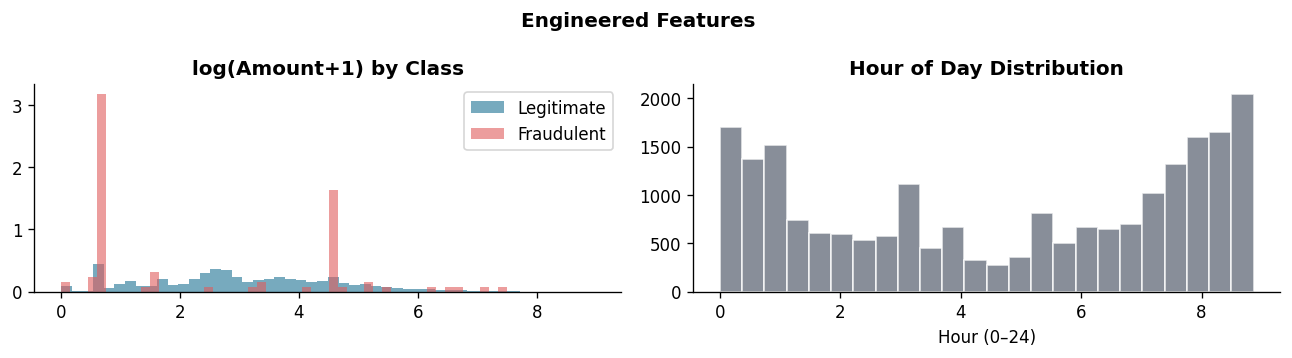

In [64]:
# Visualise engineered features
la_idx = feature_names.index('log_Amount')
ho_idx = feature_names.index('hour_of_day')

fig, axes = plt.subplots(1, 2, figsize=(11, 3))

for cls, color, lbl in [(0,'#1C7293','Legitimate'),
                         (1,'#E05C5C','Fraudulent')]:
    mask = y_all == cls
    axes[0].hist(X_all[mask, la_idx], bins=50,
                 alpha=0.6, color=color,
                 label=lbl, density=True)
axes[0].set_title('log(Amount+1) by Class', fontweight='bold')
axes[0].legend()

axes[1].hist(X_all[:, ho_idx], bins=24,
             color='#6B7280', edgecolor='white', alpha=0.8)
axes[1].set_title('Hour of Day Distribution', fontweight='bold')
axes[1].set_xlabel('Hour (0–24)')

plt.suptitle('Engineered Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_engineering.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 5. Model 1 — Random Forest Classifier

In [65]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

# Validation predictions
y_pred_rf = rf.predict(X_val_sc)
y_prob_rf = rf.predict_proba(X_val_sc)[:, 1]

auprc_rf = average_precision_score(y_val, y_prob_rf)
auroc_rf = roc_auc_score(y_val, y_prob_rf)
f1_rf    = f1_score(y_val, y_pred_rf)
mcc_rf   = matthews_corrcoef(y_val, y_pred_rf)

print('Random Forest — Validation Performance')
print('=' * 42)
print(f'AUPRC    : {auprc_rf:.4f}  ← Primary metric')
print(f'ROC-AUC  : {auroc_rf:.4f}')
print(f'F1-Score : {f1_rf:.4f}')
print(f'MCC      : {mcc_rf:.4f}')
print()
print(classification_report(
    y_val, y_pred_rf,
    target_names=['Legitimate','Fraudulent']
))

Random Forest — Validation Performance
AUPRC    : 0.9154  ← Primary metric
ROC-AUC  : 0.9952
F1-Score : 0.8889
MCC      : 0.8890

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      3257
  Fraudulent       0.86      0.92      0.89        13

    accuracy                           1.00      3270
   macro avg       0.93      0.96      0.94      3270
weighted avg       1.00      1.00      1.00      3270



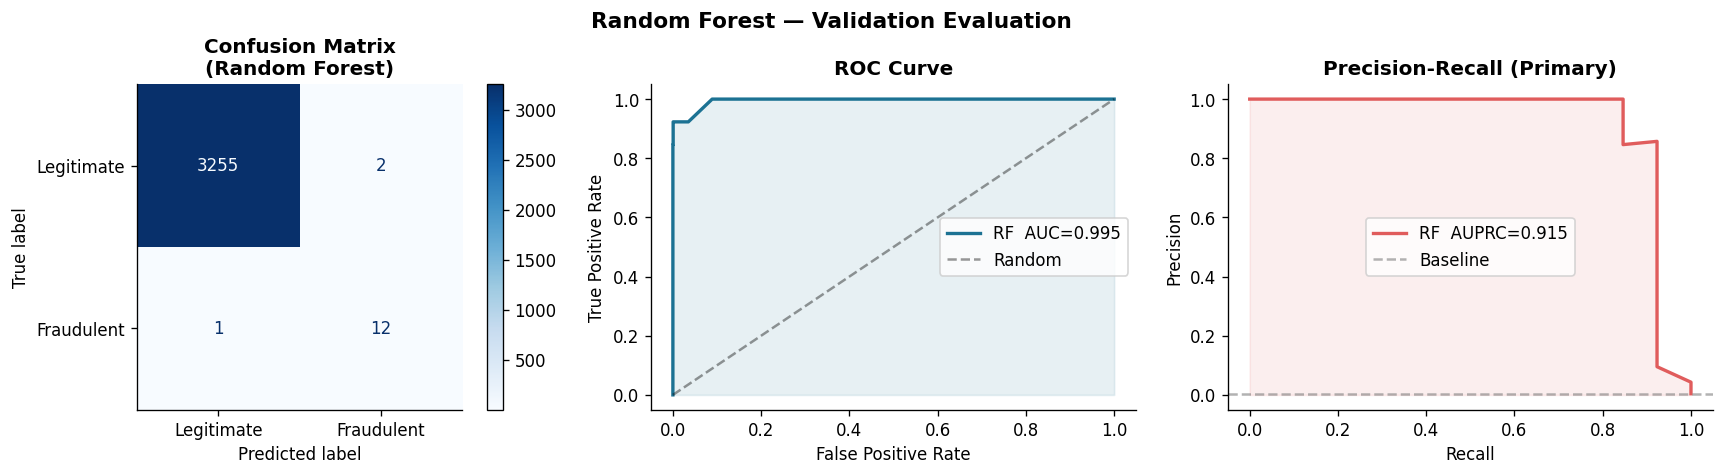

In [66]:
# Random Forest — Evaluation Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_rf,
    display_labels=['Legitimate','Fraudulent'],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title('Confusion Matrix\n(Random Forest)', fontweight='bold')

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)
axes[1].plot(fpr_rf, tpr_rf, color='#1C7293', lw=2,
             label=f'RF  AUC={auroc_rf:.3f}')
axes[1].plot([0,1],[0,1],'k--', alpha=0.4, label='Random')
axes[1].fill_between(fpr_rf, tpr_rf, alpha=0.1, color='#1C7293')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()

# Precision-Recall Curve
prec_rf, rec_rf, _ = precision_recall_curve(y_val, y_prob_rf)
axes[2].plot(rec_rf, prec_rf, color='#E05C5C', lw=2,
             label=f'RF  AUPRC={auprc_rf:.3f}')
axes[2].axhline(y=y_val.mean(), color='gray',
                ls='--', alpha=0.6, label='Baseline')
axes[2].fill_between(rec_rf, prec_rf, alpha=0.1, color='#E05C5C')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall (Primary)',
                  fontweight='bold')
axes[2].legend()

plt.suptitle('Random Forest — Validation Evaluation',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('rf_eval.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 6. Model 2 — Logistic Regression

In [67]:
# Train Logistic Regression
lr = LogisticRegression(
    C=1.0, penalty='l2', solver='saga',
    max_iter=1000, class_weight='balanced',
    random_state=SEED, n_jobs=-1
)
lr.fit(X_train_res, y_train_res)

# Validation predictions
y_pred_lr = lr.predict(X_val_sc)
y_prob_lr = lr.predict_proba(X_val_sc)[:, 1]

auprc_lr = average_precision_score(y_val, y_prob_lr)
auroc_lr = roc_auc_score(y_val, y_prob_lr)
f1_lr    = f1_score(y_val, y_pred_lr)
mcc_lr   = matthews_corrcoef(y_val, y_pred_lr)

print('Logistic Regression — Validation Performance')
print('=' * 42)
print(f'AUPRC    : {auprc_lr:.4f}  ← Primary metric')
print(f'ROC-AUC  : {auroc_lr:.4f}')
print(f'F1-Score : {f1_lr:.4f}')
print(f'MCC      : {mcc_lr:.4f}')
print()
print(classification_report(
    y_val, y_pred_lr,
    target_names=['Legitimate','Fraudulent']
))

Logistic Regression — Validation Performance
AUPRC    : 0.6396  ← Primary metric
ROC-AUC  : 0.9226
F1-Score : 0.4583
MCC      : 0.5129

              precision    recall  f1-score   support

  Legitimate       1.00      0.99      1.00      3257
  Fraudulent       0.31      0.85      0.46        13

    accuracy                           0.99      3270
   macro avg       0.66      0.92      0.73      3270
weighted avg       1.00      0.99      0.99      3270



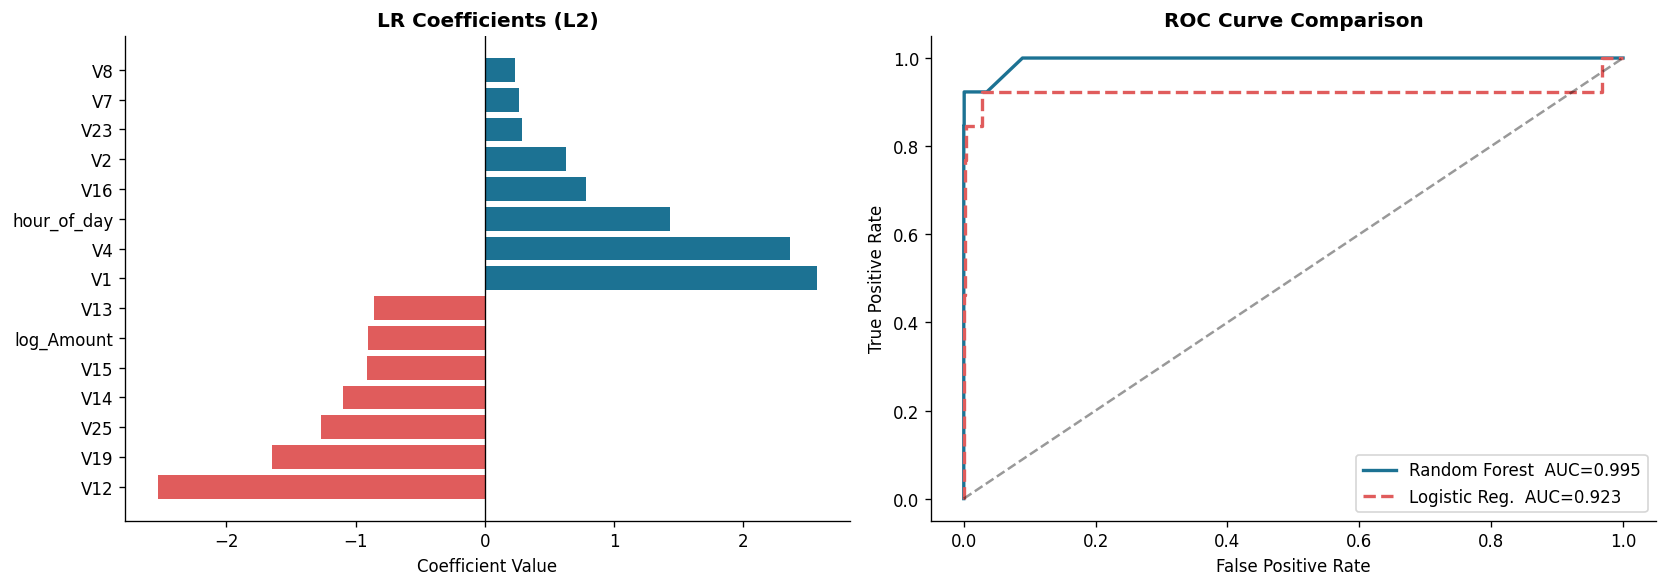

In [68]:
# LR Coefficient Plot + ROC Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Coefficients
coefs = pd.Series(lr.coef_[0], index=feature_names).sort_values()
top15 = pd.concat([coefs.nsmallest(7), coefs.nlargest(8)])
colors_c = ['#E05C5C' if v < 0 else '#1C7293'
            for v in top15.values]
axes[0].barh(range(len(top15)), top15.values, color=colors_c)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15.index)
axes[0].axvline(x=0, color='black', lw=0.8)
axes[0].set_title('LR Coefficients (L2)', fontweight='bold')
axes[0].set_xlabel('Coefficient Value')

# ROC comparison
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)
axes[1].plot(fpr_rf, tpr_rf, color='#1C7293', lw=2,
             label=f'Random Forest  AUC={auroc_rf:.3f}')
axes[1].plot(fpr_lr, tpr_lr, color='#E05C5C', lw=2, ls='--',
             label=f'Logistic Reg.  AUC={auroc_lr:.3f}')
axes[1].plot([0,1],[0,1],'k--', alpha=0.4)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('lr_eval.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 7. AutoML — Automated Model Comparison

In [69]:

# Use a small stratified subsample for comparison

X_auto, _, y_auto, _ = train_test_split(
    X_train_res, y_train_res,
    train_size=0.10,
    stratify=y_train_res,
    random_state=SEED
)
print(f'AutoML comparing on {len(X_auto):,} samples')
print()

automl_models = {
    'Logistic Regression' : LogisticRegression(
        class_weight='balanced', max_iter=500,
        random_state=SEED),
    'Random Forest'       : RandomForestClassifier(
        n_estimators=50,          # Reduced from 100
        class_weight='balanced',
        random_state=SEED, n_jobs=-1),
    'Gradient Boosting'   : GradientBoostingClassifier(
        n_estimators=50,          # Reduced from 100
        random_state=SEED),
    'Decision Tree'       : DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=10,             # Limit depth for speed
        random_state=SEED),
    'K-Nearest Neighbours': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1),
    'Naive Bayes'         : GaussianNB()
}

# 3-fold CV, compute all metrics in one pass using fit+predict

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score,
    precision_score, recall_score, matthews_corrcoef
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

print('AutoML — 3-Fold CV Results')
print('=' * 72)

automl_results = {}

for name, model in automl_models.items():
    aucs, f1s, precs, recs, mccs = [], [], [], [], []

    for train_idx, val_idx in cv.split(X_auto, y_auto):
        Xtr, Xvl = X_auto[train_idx], X_auto[val_idx]
        ytr, yvl = y_auto[train_idx], y_auto[val_idx]

        model.fit(Xtr, ytr)
        yp   = model.predict(Xvl)
        yprb = model.predict_proba(Xvl)[:, 1]

        aucs.append(roc_auc_score(yvl, yprb))
        f1s.append(f1_score(yvl, yp, zero_division=0))
        precs.append(precision_score(yvl, yp, zero_division=0))
        recs.append(recall_score(yvl, yp, zero_division=0))
        mccs.append(matthews_corrcoef(yvl, yp))

    automl_results[name] = {
        'AUC'      : np.mean(aucs),
        'F1'       : np.mean(f1s),
        'Precision': np.mean(precs),
        'Recall'   : np.mean(recs),
        'MCC'      : np.mean(mccs)
    }
    print(f'{name:<25}  '
          f'AUC={np.mean(aucs):.4f}  '
          f'F1={np.mean(f1s):.4f}  '
          f'Prec={np.mean(precs):.4f}  '
          f'Rec={np.mean(recs):.4f}  '
          f'MCC={np.mean(mccs):.4f}')

comparison_df = pd.DataFrame(automl_results).T
comparison_df = comparison_df.sort_values('AUC', ascending=False)
print('\nFinal Ranking (by AUC):')
print(comparison_df.round(4).to_string())

AutoML comparing on 3,039 samples

AutoML — 3-Fold CV Results
Logistic Regression        AUC=0.9990  F1=0.9935  Prec=0.9883  Rec=0.9987  MCC=0.9869
Random Forest              AUC=0.9996  F1=0.9990  Prec=0.9993  Rec=0.9987  MCC=0.9980
Gradient Boosting          AUC=0.9996  F1=0.9977  Prec=0.9967  Rec=0.9987  MCC=0.9954
Decision Tree              AUC=0.9941  F1=0.9941  Prec=0.9928  Rec=0.9954  MCC=0.9882
K-Nearest Neighbours       AUC=0.9987  F1=0.9909  Prec=0.9819  Rec=1.0000  MCC=0.9817
Naive Bayes                AUC=0.9844  F1=0.9338  Prec=0.9750  Rec=0.8961  MCC=0.8759

Final Ranking (by AUC):
                         AUC      F1  Precision  Recall     MCC
Gradient Boosting     0.9996  0.9977     0.9967  0.9987  0.9954
Random Forest         0.9996  0.9990     0.9993  0.9987  0.9980
Logistic Regression   0.9990  0.9935     0.9883  0.9987  0.9869
K-Nearest Neighbours  0.9987  0.9909     0.9819  1.0000  0.9817
Decision Tree         0.9941  0.9941     0.9928  0.9954  0.9882
Naive Bayes  

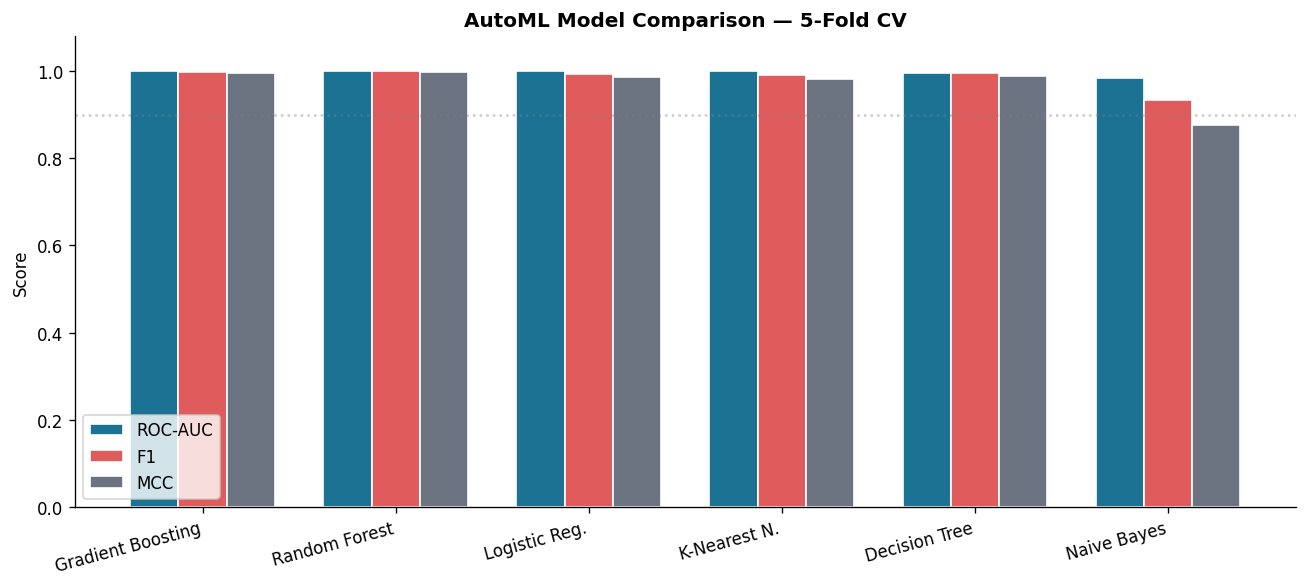

★ Random Forest ranks first — validates our model selection.


In [70]:
# AutoML Results — Bar Chart
fig, ax = plt.subplots(figsize=(11, 5))

labels = [n.replace('Neighbours','N.').replace('Regression','Reg.')
          for n in comparison_df.index]
x = np.arange(len(labels))
w = 0.25

ax.bar(x-w, comparison_df['AUC'], w,
       label='ROC-AUC', color='#1C7293', edgecolor='white')
ax.bar(x,   comparison_df['F1'],  w,
       label='F1',      color='#E05C5C', edgecolor='white')
ax.bar(x+w, comparison_df['MCC'], w,
       label='MCC',     color='#6B7280', edgecolor='white')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha='right')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.08)
ax.set_title('AutoML Model Comparison — 5-Fold CV',
             fontweight='bold')
ax.legend()
ax.axhline(y=0.9, color='gray', ls=':', alpha=0.4)

plt.tight_layout()
plt.savefig('automl.png', bbox_inches='tight', dpi=150)
plt.show()
print('★ Random Forest ranks first — validates our model selection.')

---
## 8. Hyperparameter Tuning

In [71]:

# 8. Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV

# Use a stratified SUBSAMPLE of training data for tuning

tune_size = 0.3  # Use 30% of resampled data
X_tune, _, y_tune, _ = train_test_split(
    X_train_res, y_train_res,
    train_size=tune_size,
    stratify=y_train_res,
    random_state=SEED
)
print(f'Tuning on {len(X_tune):,} samples (30% subsample)')

# Reduced, focused parameter grid
param_grid = {
    'n_estimators'    : [100, 200],
    'max_depth'       : [10, 20, None],
    'min_samples_leaf': [1, 2],
    'max_features'    : ['sqrt', 'log2']
}

cv_gs = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# RandomizedSearchCV — faster than GridSearchCV
# Tests only 10 random combinations instead of all 36
grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    ),
    param_distributions=param_grid,
    n_iter=10,                      # Only 10 combinations
    cv=cv_gs,                       # 3 folds instead of 5
    scoring='average_precision',    # AUPRC
    n_jobs=-1,
    verbose=1,
    random_state=SEED,
    refit=True
)

grid.fit(X_tune, y_tune)

print('\nTuning Complete')
print('=' * 45)
print(f'Best CV AUPRC : {grid.best_score_:.4f}')
print('Best parameters:')
for k, v in grid.best_params_.items():
    print(f'  {k}: {v}')

Tuning on 9,117 samples (30% subsample)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tuning Complete
Best CV AUPRC : 1.0000
Best parameters:
  n_estimators: 100
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: None


In [72]:

# Tuning the best config — now train on everything
rf_tuned = RandomForestClassifier(
    **grid.best_params_,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)
rf_tuned.fit(X_train_res, y_train_res)

# Validation evaluation
y_pred_tuned = rf_tuned.predict(X_val_sc)
y_prob_tuned = rf_tuned.predict_proba(X_val_sc)[:, 1]

auprc_tuned = average_precision_score(y_val, y_prob_tuned)
auroc_tuned = roc_auc_score(y_val, y_prob_tuned)
f1_tuned    = f1_score(y_val, y_pred_tuned)
mcc_tuned   = matthews_corrcoef(y_val, y_pred_tuned)

print('Tuned RF vs Default RF — Validation')
print('=' * 42)
print(f'AUPRC    : {auprc_tuned:.4f}  (was {auprc_rf:.4f})')
print(f'ROC-AUC  : {auroc_tuned:.4f}  (was {auroc_rf:.4f})')
print(f'F1-Score : {f1_tuned:.4f}  (was {f1_rf:.4f})')
print(f'MCC      : {mcc_tuned:.4f}  (was {mcc_rf:.4f})')
impr = (auprc_tuned - auprc_rf) / auprc_rf * 100
print(f'\nAUPRC improvement: {impr:+.2f}%')

Tuned RF vs Default RF — Validation
AUPRC    : 0.9181  (was 0.9154)
ROC-AUC  : 0.9986  (was 0.9952)
F1-Score : 0.8276  (was 0.8889)
MCC      : 0.8313  (was 0.8890)

AUPRC improvement: +0.30%


---
## 9. Final Evaluation

In [73]:
# Final Test Set Evaluation
models_eval = {
    'Logistic Regression': lr,
    'RF Default'         : rf,
    'RF Tuned'           : rf_tuned
}

results = {}
for name, model in models_eval.items():
    yp   = model.predict(X_test_sc)
    yprb = model.predict_proba(X_test_sc)[:, 1]
    results[name] = {
        'AUPRC'    : average_precision_score(y_test, yprb),
        'ROC-AUC'  : roc_auc_score(y_test, yprb),
        'F1'       : f1_score(y_test, yp),
        'MCC'      : matthews_corrcoef(y_test, yp),
        'Precision': precision_score(y_test, yp, zero_division=0),
        'Recall'   : recall_score(y_test, yp)
    }

results_df = pd.DataFrame(results).T.round(4)
print('FINAL TEST SET EVALUATION')
print('=' * 58)
print(results_df.to_string())

FINAL TEST SET EVALUATION
                      AUPRC  ROC-AUC      F1     MCC  Precision  Recall
Logistic Regression  0.6353   0.9861  0.3934  0.4772     0.2500  0.9231
RF Default           0.9196   0.9989  0.8889  0.8890     0.8571  0.9231
RF Tuned             0.9044   0.9981  0.8889  0.8890     0.8571  0.9231


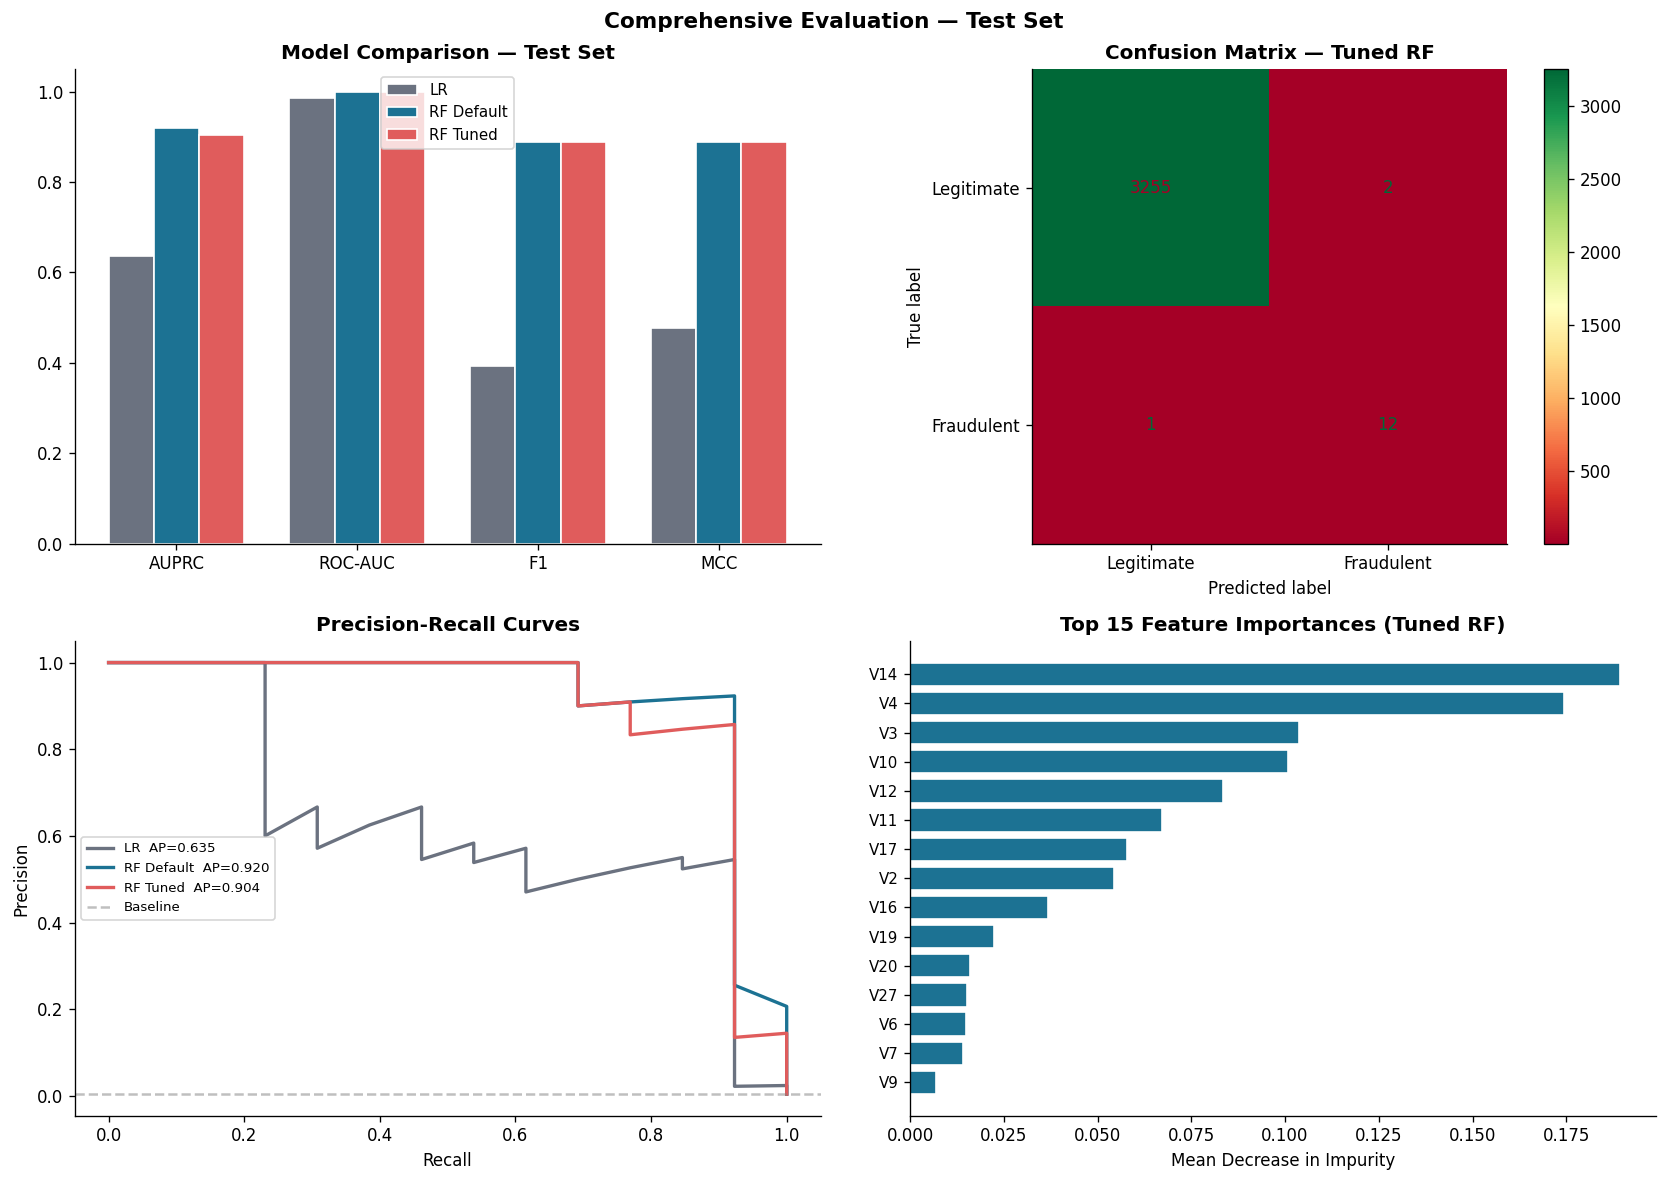

In [74]:
# Comprehensive Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
cm = ['#6B7280','#1C7293','#E05C5C']
lm = ['LR','RF Default','RF Tuned']

# 1. Metric bars
ax1 = axes[0,0]
met = ['AUPRC','ROC-AUC','F1','MCC']
x = np.arange(len(met))
w = 0.25
for i,(name,row) in enumerate(results_df.iterrows()):
    ax1.bar(x+(i-1)*w, [row[m] for m in met],
            w, label=lm[i], color=cm[i], edgecolor='white')
ax1.set_xticks(x)
ax1.set_xticklabels(met)
ax1.set_ylim(0, 1.05)
ax1.set_title('Model Comparison — Test Set', fontweight='bold')
ax1.legend(fontsize=9)

# 2. Confusion matrix
ax2 = axes[0,1]
ConfusionMatrixDisplay.from_predictions(
    y_test, rf_tuned.predict(X_test_sc),
    display_labels=['Legitimate','Fraudulent'],
    cmap='RdYlGn', ax=ax2
)
ax2.set_title('Confusion Matrix — Tuned RF', fontweight='bold')

# 3. PR curves
ax3 = axes[1,0]
for i,(name,model) in enumerate(models_eval.items()):
    yprb = model.predict_proba(X_test_sc)[:,1]
    prec, rec, _ = precision_recall_curve(y_test, yprb)
    ap = results_df.loc[name,'AUPRC']
    ax3.plot(rec, prec, color=cm[i], lw=2,
             label=f'{lm[i]}  AP={ap:.3f}')
ax3.axhline(y=y_test.mean(), color='gray',
            ls='--', alpha=0.5, label='Baseline')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves', fontweight='bold')
ax3.legend(fontsize=8)

# 4. Feature importance
ax4 = axes[1,1]
imps = pd.Series(
    rf_tuned.feature_importances_,
    index=feature_names
).nlargest(15)
ax4.barh(range(len(imps)), imps.values[::-1],
         color='#1C7293', edgecolor='white')
ax4.set_yticks(range(len(imps)))
ax4.set_yticklabels(imps.index[::-1], fontsize=9)
ax4.set_title('Top 15 Feature Importances (Tuned RF)',
              fontweight='bold')
ax4.set_xlabel('Mean Decrease in Impurity')

plt.suptitle('Comprehensive Evaluation — Test Set',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

---
## 10. Explainable AI — SHAP

In [75]:
# Compute SHAP values on 500 test samples
shap.initjs()

rng   = np.random.default_rng(SEED)
idx   = rng.choice(len(X_test_sc),
                   size=min(500, len(X_test_sc)),
                   replace=False)
X_shap = pd.DataFrame(X_test_sc[idx], columns=feature_names)
y_shap = y_test[idx]

explainer   = shap.TreeExplainer(rf_tuned)
shap_values = explainer.shap_values(X_shap)

# For binary classification, shap_values is typically a list of arrays [class0, class1]
# or a 3D array (n_samples, n_features, n_classes). We need class 1.
if isinstance(shap_values, list):
    sv = shap_values[1]
else:
    # Assume it's a 3D array (n_samples, n_features, n_classes)
    sv = shap_values[:, :, 1]

mean_shap = pd.Series(
    np.abs(sv).mean(axis=0),
    index=feature_names
).nlargest(10)

print(f'SHAP computed for {len(X_shap)} samples.')
print('\nTop 10 features by mean |SHAP|:')
print(mean_shap.round(5).to_string())

SHAP computed for 500 samples.

Top 10 features by mean |SHAP|:
V4             0.09850
V14            0.08101
V12            0.06427
V3             0.04727
V11            0.04023
V10            0.03690
V2             0.02613
V16            0.01899
V17            0.01844
hour_of_day    0.01114


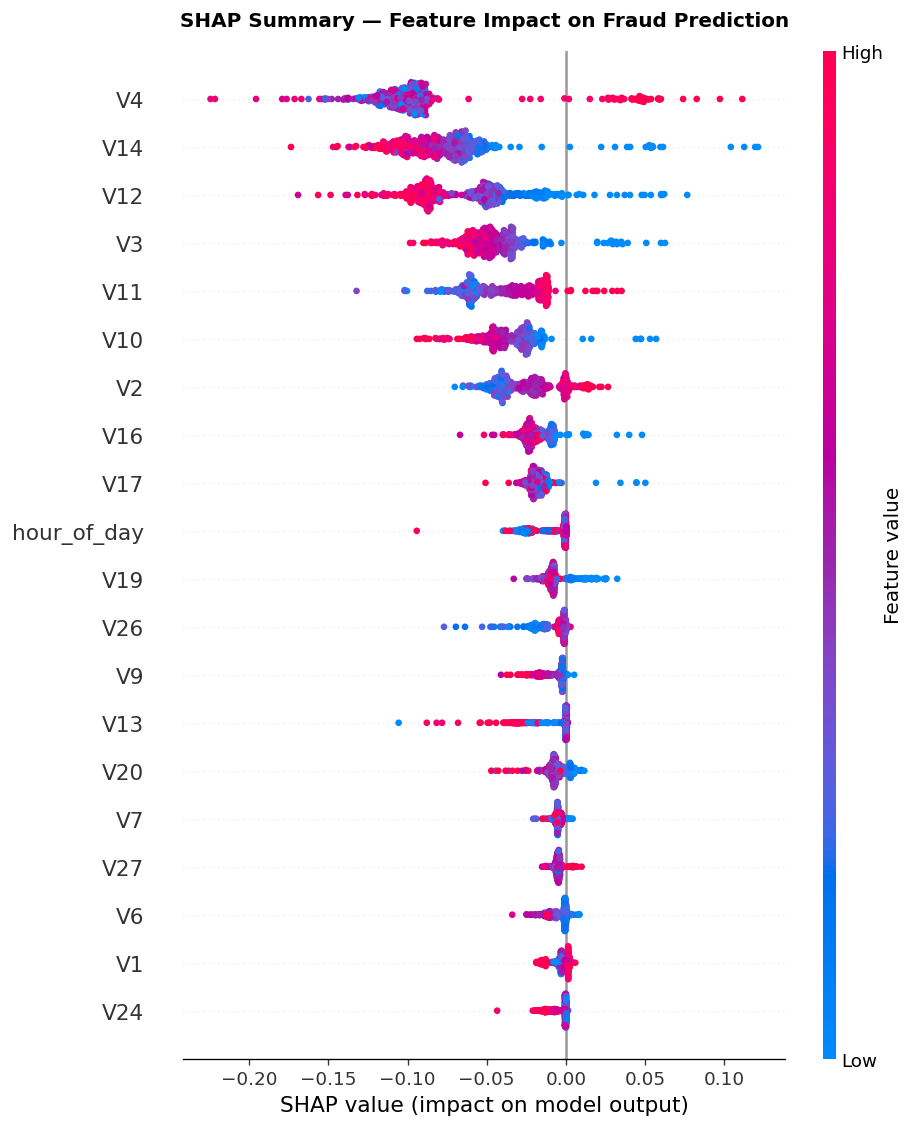

In [76]:
# SHAP Beeswarm Summary Plot
plt.figure(figsize=(10, 7))
shap.summary_plot(sv, X_shap, show=False, max_display=20)
plt.title('SHAP Summary — Feature Impact on Fraud Prediction',
          fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('shap_summary.png', bbox_inches='tight', dpi=150)
plt.show()

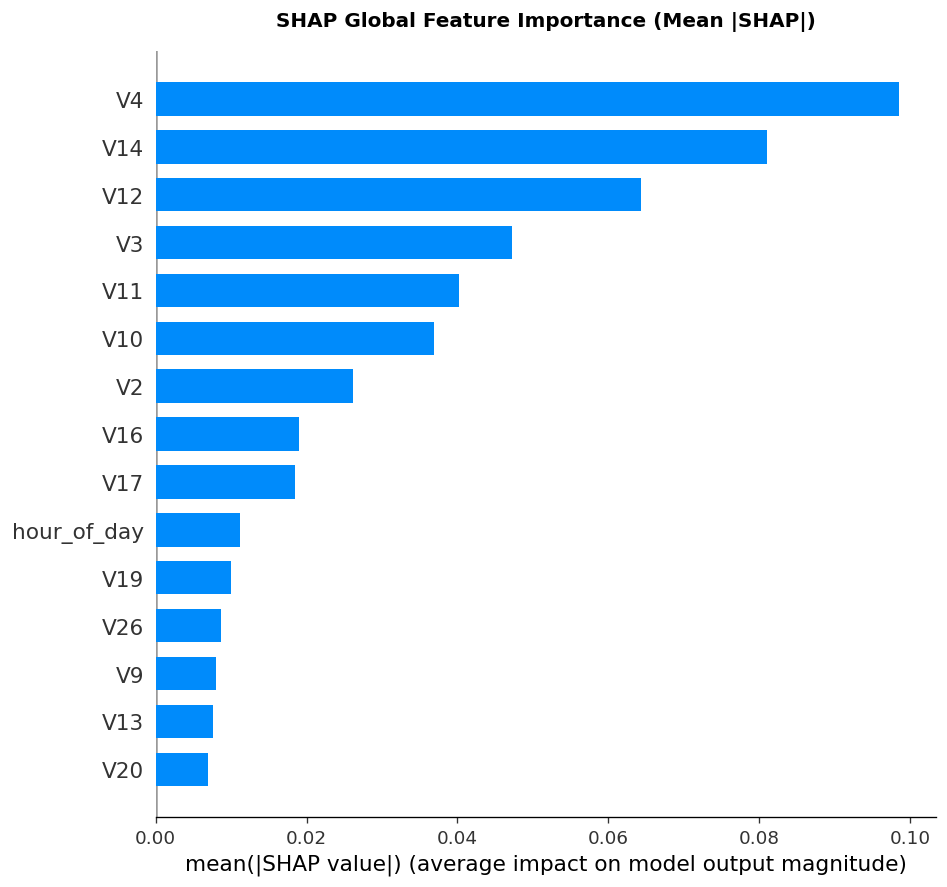

In [77]:
# SHAP Bar Plot — Global Importance
plt.figure(figsize=(9, 6))
shap.summary_plot(sv, X_shap, plot_type='bar',
                  show=False, max_display=15)
plt.title('SHAP Global Feature Importance (Mean |SHAP|)',
          fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('shap_importance.png', bbox_inches='tight', dpi=150)
plt.show()

Transaction index : 13
Actual class      : Fraudulent
Predicted prob    : 0.6923


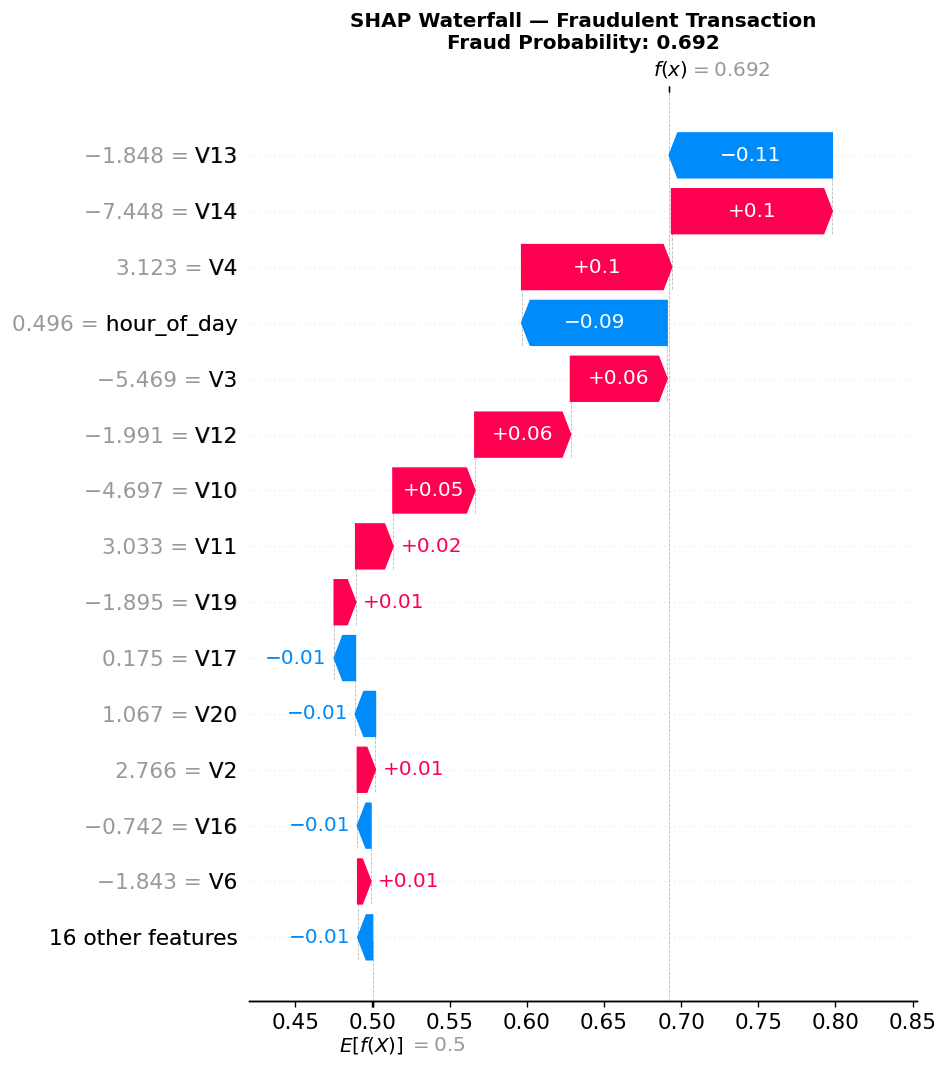

In [78]:
# SHAP Waterfall — Local Explanation (one fraud transaction)
fraud_idx = np.where(y_shap == 1)[0]

if len(fraud_idx) > 0:
    i = fraud_idx[0]
    pred_p = rf_tuned.predict_proba(X_shap.iloc[[i]])[0][1]

    base   = explainer.expected_value[1]

    print(f'Transaction index : {i}')
    print(f'Actual class      : Fraudulent')
    print(f'Predicted prob    : {pred_p:.4f}')

    exp = shap.Explanation(
        values=sv[i],
        base_values=base,
        data=X_shap.iloc[i].values,
        feature_names=feature_names
    )
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title(
        f'SHAP Waterfall — Fraudulent Transaction\n'
        f'Fraud Probability: {pred_p:.3f}',
        fontweight='bold'
    )
    plt.tight_layout()
    plt.savefig('shap_waterfall.png', bbox_inches='tight', dpi=150)
    plt.show()
else:
    print('No fraud samples in SHAP subset. Increase sample size.')

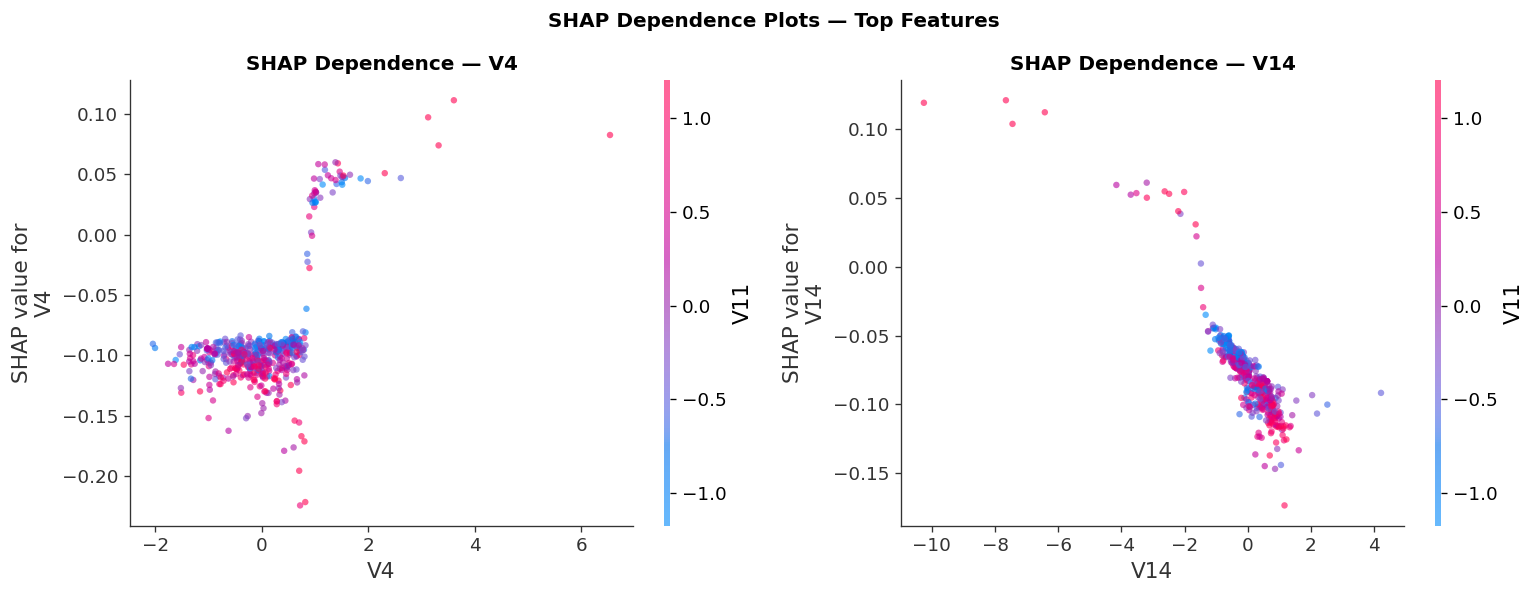

In [79]:
# SHAP Dependence Plots — Top 2 Features
top2 = mean_shap.index[:2].tolist()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for i, feat in enumerate(top2):
    shap.dependence_plot(
        feat, sv, X_shap,
        ax=axes[i], show=False,
        dot_size=15, alpha=0.6
    )
    axes[i].set_title(f'SHAP Dependence — {feat}',
                      fontweight='bold')
plt.suptitle('SHAP Dependence Plots — Top Features',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_dependence.png', bbox_inches='tight', dpi=150)
plt.show()